# Aproximación a valores de Black-Scholes por método de redes neuronales
Se subió a Google Drive un [archivo .csv](https://github.com/sanarovaz/ML-Black-Scholes/blob/main/BSSim.csv) conteniendo los valores de 500.000 combinaciones de parámetros y su correspondiente valor a partir de la fórmula de Black-Scholes. Para la obtención de esos valores se emplearon la función runif( ) y la función blackscholes( ) del paquete ragtop, en R.

---

Recuérdese la fórmula de Black-Scholes para opciones europeas


$$C(S_0,t)=S_0N(d_1)-Ke^{-r(T-t)}N(d_2)$$
$$P(S_0,t)=Ke^{-r(T-t)}N(-d_2)-S_0N(-d_1)$$
con
- $d_1=\frac{\ln\frac{S_0}{K}+(r+\frac{\sigma^2}{2})(T-t)}{\sigma\sqrt{T-t}}$
- $d_2=d_1-\sigma\sqrt{T-t}=\frac{\ln\frac{S_0}{K}+(r-\frac{\sigma^2}{2})(T-t)}{\sigma\sqrt{T-t}}$
- $S_0$: Precio de la acción
- $C(S_0,t)$: Precio de Call
- $K$: Precio de strike
- $(T-t)$: Madurez
- $\sigma$: Volatilidad (desvío estándar del logaritmo de los retornos)
- $r$: Tasa Libre de Riesgo
- $N(x)$: Función de distribución acumulada de la normal estándar





Los parámetros fueron obtenidos de manera pseudoaleatoria con una distribución uniforme entre los siguientes rangos:


| Parámetro              |   Rango           |
|:-----------------------|:------------------|
| Precio de la acción $(S)$    | \\$10 — \\$500     |
| Precio de strike $(K)$     |  \\$0,1 — \\$1000    |
| Madurez $(T-t)$       | 1 día - 3 años  |
| Tasa de dividendos $(q)$    | 0\% — 5\%         |
| Tasa Libre de Riesgo $(r)$   | 1\% — 5\%         |
| Volatilidad $(\sigma)$  | 1\% — 99,99\%        |
| Precio de Call $(C)$       |  \\$0 — \\$23045,77    |

## Código

In [13]:
from google.colab import drive
drive.mount('/content/drive')
drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<module 'google.colab.drive' from '/usr/local/lib/python3.7/dist-packages/google/colab/drive.py'>

In [14]:
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy import stats
import matplotlib
matplotlib.rcParams['figure.dpi'] = 150

In [15]:
path = '/content/drive/MyDrive/Colab Notebooks/BSSim.csv'

In [16]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BSSim.csv').drop(['Unnamed: 0'], axis= 1)
df

,Stock Price,Strike Price,Maturity,Dividend Rate,Volatility,Risk-Free Rate,Call Price
0,255.041042,950.744397,1.969097,0.010443,0.718442,0.095498,2.611228e+01
1,368.552012,621.011641,1.284498,0.018675,0.445279,0.081265,2.336295e+01
2,60.413555,603.651758,0.952611,0.010442,0.987656,0.052811,5.193936e-01
3,290.442086,949.842427,2.481747,0.006238,0.155186,0.095643,1.049972e-03
4,170.439907,445.413954,0.427126,0.036164,0.595567,0.016510,2.160785e-01
...,...,...,...,...,...,...,...
499995,115.986656,504.959382,2.860278,0.041467,0.456905,0.082281,2.379752e+00
499996,449.113434,778.358943,0.971457,0.046959,0.157285,0.083839,1.026697e-02
499997,388.330313,724.784668,2.170198,0.018781,0.014243,0.041413,5.401457e-166
499998,219.441420,323.686003,1.785220,0.020249,0.103391,0.083503,2.873002e-01


---
Resumimos algunas de las principales medidas de posición y dispersión.

In [17]:
df['Call Price'].describe()

count    500000.000000
mean         62.328677
std          94.397183
min           0.000000
25%           0.007399
50%          11.816179
75%          91.843662
max         495.938269
Name: Call Price, dtype: float64

Nótese que los datos de esta muestra generada aleatoriamente en R presenta una marcada asimetría positiva (concentración de frecuencia de los menores valores del dominio), que contrasta con la mucho menor asimetría del dataset empleado en el curso. Ésto puede ser causado por el método de generación de los datos, y quizá podría corregirse empleando algoritmos de generación de variable con distribuciones no-uniformes.



## Normalización

Normalizamos los datos, apoyándonos en la propiedad de la fórmula de Black-Scholes:

$C(S,K)/K = C(S/K, 1)$


In [18]:
df["Stock Price"] = df["Stock Price"]/df["Strike Price"]
df["Call Price"] = df["Call Price"]/df["Strike Price"]
df["Strike Price"] = df["Strike Price"]/df["Strike Price"]
df

,Stock Price,Strike Price,Maturity,Dividend Rate,Volatility,Risk-Free Rate,Call Price
0,0.268254,1.0,1.969097,0.010443,0.718442,0.095498,2.746509e-02
1,0.593470,1.0,1.284498,0.018675,0.445279,0.081265,3.762080e-02
2,0.100080,1.0,0.952611,0.010442,0.987656,0.052811,8.604192e-04
3,0.305779,1.0,2.481747,0.006238,0.155186,0.095643,1.105418e-06
4,0.382655,1.0,0.427126,0.036164,0.595567,0.016510,4.851183e-04
...,...,...,...,...,...,...,...
499995,0.229695,1.0,2.860278,0.041467,0.456905,0.082281,4.712759e-03
499996,0.577000,1.0,0.971457,0.046959,0.157285,0.083839,1.319053e-05
499997,0.535787,1.0,2.170198,0.018781,0.014243,0.041413,7.452499e-169
499998,0.677945,1.0,1.785220,0.020249,0.103391,0.083503,8.875891e-04


## Entrenamiento del modelo
Se modela una red neuronal con 4 capas de 100 neuronas cada una, con un máximo de 5 iteraciones de entrenamiento. Para ésto se emplean algoritmos de SciKit, en particular [MLPRegressor](https://scikit-learn.org/stable/modules/neural_networks_supervised.html), que emplea un perceptrón multicapa que entrena vía retropropagación y emplea error cuadrado como su función de costo.

Para validar nuestro modelo, particionaremos nuestra muestra de 500.000 datos en un grupo que incluya al 80% (400.000 datos) seleccionados aleatoriamente y un grupo que contenga al 20% (100.000 datos) restante.

Emplearemos el primer grupo para entrenar al modelo, esperando que le permita generar una red que logre predecir efectivamente los valores correspondientes al segundo grupo.

In [27]:
np.random.seed(237)
X_train, X_test, y_train, y_test = train_test_split(df.drop('Call Price', axis=1), 
                                                    df['Call Price'], test_size=0.2)

mlp = MLPRegressor(hidden_layer_sizes=(100,100,100,100), 
                   solver='adam', shuffle = False, batch_size=64, verbose=True,
                   max_iter= 5
                    ) 

In [28]:
np.random.seed(237)
mlp.fit(X_train, y_train)

Iteration 1, loss = 213.61281358
Iteration 2, loss = 164.03065278
Iteration 3, loss = 213.72765747
Iteration 4, loss = 262.59395452
Iteration 5, loss = 147.08965353


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPRegressor(batch_size=64, hidden_layer_sizes=(100, 100, 100, 100), max_iter=5,
             shuffle=False, verbose=True)

A continuación se computan los valores de $R^2$. 

In [29]:
print("Valor en el conjunto de entrenamiento: %f" % mlp.score(X_train, y_train))
print("Valor en el conjunto de prueba: %f" % mlp.score(X_test, y_test))

Valor en el conjunto de entrenamiento: 0.995725
Valor en el conjunto de prueba: 0.997317


> Nótese que cuando se intentó buscó construir el modelo con un máximo de 20 iteraciones de entrenamiento, los valores de $R^2$ fueron significativamente menores (debajo de 85%).




## Visualización del modelo



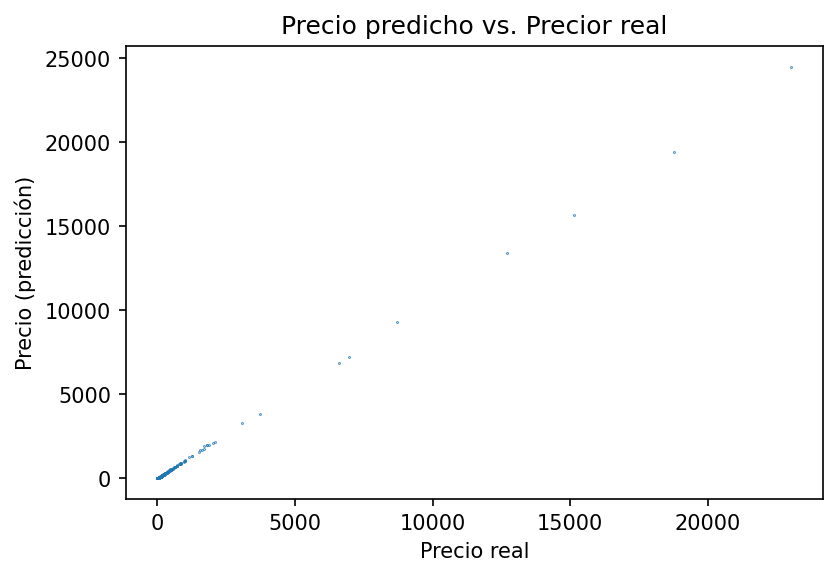

In [34]:
preds_test = mlp.predict(X_test)
plt.scatter(y_test, preds_test, s= 0.1)
plt.ylabel("Precio (predicción)")
plt.xlabel("Precio real")
plt.title("Precio predicho vs. Precio real")
plt.show()

Como ya se mencionó, existe una marcada asimetría en los datos. Ésto causa que el gráfico, si bien parece indicar la eficiencia del modelo, presente datos muy dispersos para precios mayores a 2500. Es posible que la asimetría cause algún tipo de distorsión, por lo que procedemos a visualizar el gráfico centrados en los valores menores al cuantil 99 de cada set.

In [59]:
np.quantile(preds_test, 0.99), np.quantile(y_test, 0.99)

(26.26112497291188, 23.283158260298574)

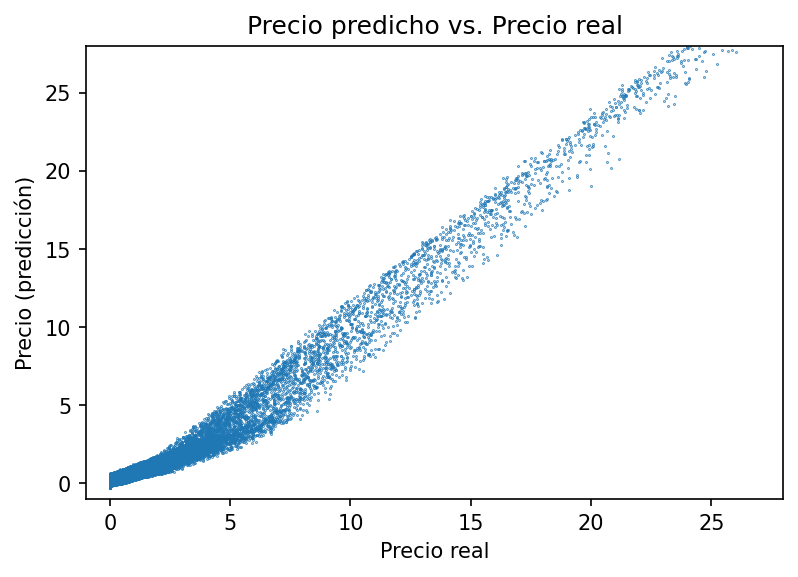

In [63]:
preds_test = mlp.predict(X_test)
plt.scatter(y_test, preds_test, s= 0.1)
plt.ylabel("Precio (predicción)")
plt.xlabel("Precio real")
plt.title("Precio predicho vs. Precio real")
plt.xlim([-1, 28])
plt.ylim([-1, 28])
plt.show()

Notamos que la variación es algo mayor a la aparente en el primer scatterplot. Se debe estudiar los efectos de volver a entrenar al modelo sin los outliers.



---

Procedo a hacerlo a continuación, incluyendo los datos correspondientes al 97.5% de menores valores de precio de call.

In [70]:
q975 = df['Call Price'].quantile(0.975)
df1 = df[df['Call Price'] <= q975]
df1.sort_values('Call Price')

,Stock Price,Strike Price,Maturity,Dividend Rate,Volatility,Risk-Free Rate,Call Price
434875,0.040625,1.0,0.006872,0.018042,0.424260,0.069501,0.000000
454811,0.359674,1.0,0.321287,0.033024,0.037559,0.099983,0.000000
331049,0.131229,1.0,1.296533,0.009497,0.021248,0.075631,0.000000
208374,0.040730,1.0,0.558959,0.008917,0.107385,0.092028,0.000000
25386,0.389275,1.0,0.004400,0.001735,0.027386,0.064455,0.000000
...,...,...,...,...,...,...,...
213306,9.852137,1.0,1.033353,0.018963,0.708847,0.056555,8.718064
49450,9.943726,1.0,1.967984,0.014067,0.171446,0.025653,8.721448
320191,9.845619,1.0,0.277261,0.048414,0.450175,0.034671,8.723908
71127,10.478973,1.0,2.567880,0.034225,0.348362,0.052734,8.723990


Reitero el procedimiento anterior

In [73]:
np.random.seed(237)
X1_train, X1_test, y1_train, y1_test = train_test_split(df1.drop('Call Price', axis=1), 
                                                    df1['Call Price'], test_size=0.2)

mlp1 = MLPRegressor(hidden_layer_sizes=(100,100,100,100), 
                   solver='adam', shuffle = False, batch_size=64, verbose=True,
                   max_iter= 5
                    ) 

In [74]:
np.random.seed(237)
mlp1.fit(X1_train, y1_train)

Iteration 1, loss = 0.00188228
Iteration 2, loss = 0.00035028
Iteration 3, loss = 0.00023825
Iteration 4, loss = 0.00019806
Iteration 5, loss = 0.00018299


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPRegressor(batch_size=64, hidden_layer_sizes=(100, 100, 100, 100), max_iter=5,
             shuffle=False, verbose=True)

Valor en el conjunto de entrenamiento: 0.999922
Valor en el conjunto de prueba: 0.999924


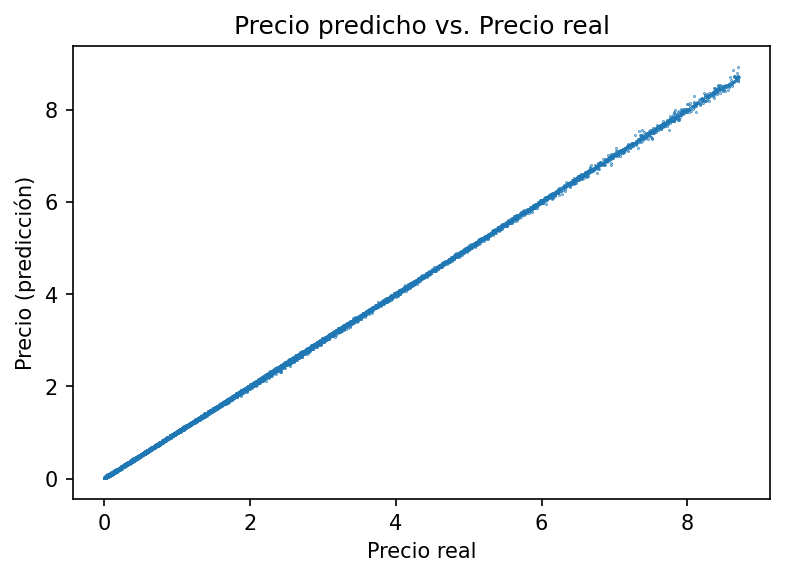

In [78]:
print("Valor en el conjunto de entrenamiento: %f" % mlp1.score(X1_train, y1_train))
print("Valor en el conjunto de prueba: %f" % mlp1.score(X1_test, y1_test))

preds_test1 = mlp1.predict(X1_test)
plt.scatter(y1_test, preds_test1, s= 0.1)
plt.ylabel("Precio (predicción)")
plt.xlabel("Precio real")
plt.title("Precio predicho vs. Precio real")
plt.show()

Vemos que tanto el $R^2$ como la correlación marcada en el scatterplot mejoraron significativamente en el intervalo. Esto parecería indicar que los outliers causaban que el modelo se modifique de modo de generar aproximaciones imprecisas para una gran proporción de los valores.

